# the German tank problem

the Germans have a population of $n$ tanks labeled with serial numbers $1,2,...,n$ on the tanks. The number of tanks $n$ is unknown and of interest to the Allied forces. The Allied forces randomly capture $k$ tanks from the Germans with replacement and observe their serial numbers $\{x_1, x_2, ..., x_k\}$. The goal is to, from observing the serial numbers on this random sample of the tanks, estimate $n$.

the *estimator* of $n$ maps an outcome of the experiment to an estimate of $n$, $\hat{n}$.

In [1]:
using StatsBase
using PyPlot
using Statistics
using Printf

PyPlot.matplotlib.style.use("seaborn-pastel")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

## data structure for a tank

for elegance

In [2]:
struct Tank
    serial_no::Int
end

## visualizing the captured tanks and their serial numbers

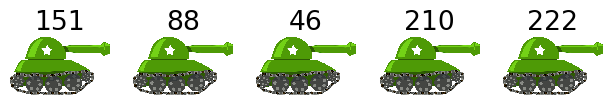

In [3]:
function viz_tanks(tanks::Array{Tank}, savename=nothing)
    nb_tanks = length(tanks)
    
    img = PyPlot.matplotlib.image.imread("tank.png")

    fig, ax = subplots(1, nb_tanks)
    for (t, tank) in enumerate(tanks)
        ax[t].imshow(img)
        ax[t].set_title(tank.serial_no)
        ax[t].axis("off")
    end
    tight_layout()
    
    if ! isnothing(savename)
        savefig(savename * ".png", format="png", dpi=300)
        # Linux command line tool to trim white space
        run(`convert $savename.png -trim $savename.png`)
    end
end

tanks = [Tank(rand(1:500)) for i = 1:5]
viz_tanks(tanks)

## simulating tank capture

write a function `capture_tanks` to simulate the random sampling of `nb_tanks_captured` tanks from all `nb_tanks` tanks the Germans have (without replacement). return a random sample of tanks.

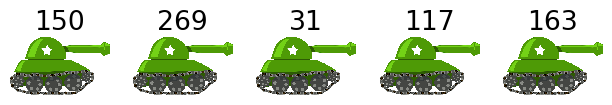

In [4]:
function capture_tanks(nb_tanks_captured::Int, nb_tanks::Int)
    serial_nos = sample(1:nb_tanks, nb_tanks_captured, replace=false)
    return [Tank(serial_no) for serial_no in serial_nos]
end

captured_tanks = capture_tanks(5, 300)
viz_tanks(captured_tanks)

## defining different estimators

an estimator maps an outcome $\{x_1, x_2, ..., x_k\}$ to an estimate for $n$, $\hat{n}$.

### estimator (1): maximum serial number

this is the maximum likelihood estimator.

\begin{equation}
\hat{n} = \max_i x_i
\end{equation}

In [5]:
function max_serial_no(tanks::Array{Tank})
    serial_nos = [tank.serial_no for tank in tanks]
    return maximum(serial_nos)
end

max_serial_no(captured_tanks)

269

### estimator (2): maximum serial number plus initial gap

\begin{equation}
\hat{n} = \max_i x_i + \bigl(\min_i x_i -1\bigr)
\end{equation}

In [6]:
function max_serial_no_plus_initial_gap(tanks::Array{Tank})
    serial_nos = [tank.serial_no for tank in tanks]
    return maximum(serial_nos) + minimum(serial_nos) - 1
end

max_serial_no_plus_initial_gap (generic function with 1 method)

### estimator (3): maximum serial number plus gap if samples are evenly spaced

\begin{equation}
\hat{n} = \max_i x_i + \bigl( \max_i x_i / k -1 \bigr)
\end{equation}

In [7]:
function max_serial_no_plus_gap_if_evenly_spaced(tanks::Array{Tank})
    serial_nos = [tank.serial_no for tank in tanks]
    return maximum(serial_nos) * (1 + 1 / length(tanks)) - 1
end

max_serial_no_plus_gap_if_evenly_spaced (generic function with 1 method)

## assessing the bias and variance of different estimators

say the Germans have `nb_tanks` tanks, and we randomly capture `nb_tanks_captured`. what is the distribution of the estimators (over different outcomes of this random experiment), and how does the distribution compare to the true `nb_tanks`?

In [8]:
"""
Perform `nb_sims` simulations of capturing `nb_tanks_captured` from `nb_tanks` total tanks w./o replacement.
Use the `estimator` function to map the captured array of tanks to an estimate of n in each simulation.
Return an array of estimated numbers of tanks from the simulations
"""
function sim_̂n(nb_sims::Int, nb_tanks::Int, nb_tanks_captured::Int, estimator::Function)
    # perform `nb_sims` of tank capture, collect estimates of n
    estimated_nb_tanks = zeros(nb_sims)
    for s = 1:nb_sims
        captured_tanks = capture_tanks(nb_tanks_captured, nb_tanks)
        estimated_nb_tanks[s] = estimator(captured_tanks)
    end
    return estimated_nb_tanks
end

sim_̂n

In [9]:
nb_sims = 10000 # how many times we simulate tank capture to get the dist'n of the estimators

nb_tanks = 100 # n
nb_tanks_captured = 5 # k

5

estimator (1)
	mean estimate: 84.2296
	standard deviation: 13.626769709849524


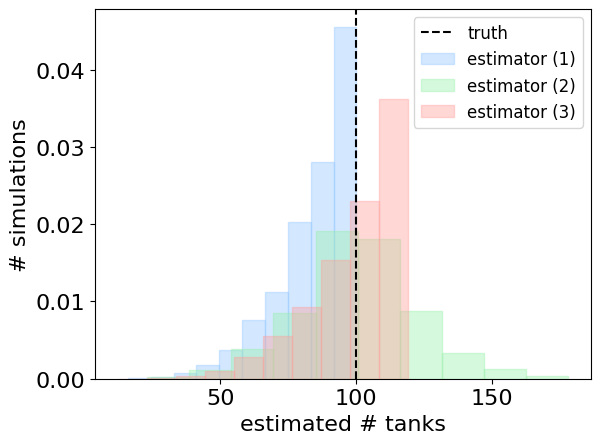

estimator (2)
	mean estimate: 100.1518
	standard deviation: 21.72349299203002
estimator (3)
	mean estimate: 99.94963999999999
	standard deviation: 16.537268819136962


PyObject <matplotlib.legend.Legend object at 0x7fa0afcd60b8>

In [10]:
# an array of functions!
estimators = [max_serial_no, max_serial_no_plus_initial_gap, max_serial_no_plus_gap_if_evenly_spaced]

# loop over estimators
for e = 1:3
    estimated_nb_tanks = sim_̂n(nb_sims, nb_tanks, nb_tanks_captured, estimators[e])
    
    # plot histogram of estimator to viz its dist'n
    hist(estimated_nb_tanks, label="estimator ($e)", 
        alpha=0.4, density=true, ec=@sprintf("C%d", e - 1))
    
    println("estimator ($e)")
    println("\tmean estimate: ", mean(estimated_nb_tanks))
    println("\tstandard deviation: ", std(estimated_nb_tanks))
end
xlabel("estimated # tanks")
ylabel("# simulations")
# plot true value for comparison
axvline(x=nb_tanks, color="k", linestyle="--", label="truth")
legend(prop=Dict("size" => 12))

estimator (1) is biased.

estimator (2) is unbiased but has a high variance.

estimator (3) is unbiased and has a low variance. it can be shown that estimator (3) is the minimum-variance, unbiased estimator!

## what happens as we capture more and more tanks, i.e. increase $k$?

assess estimator (3).

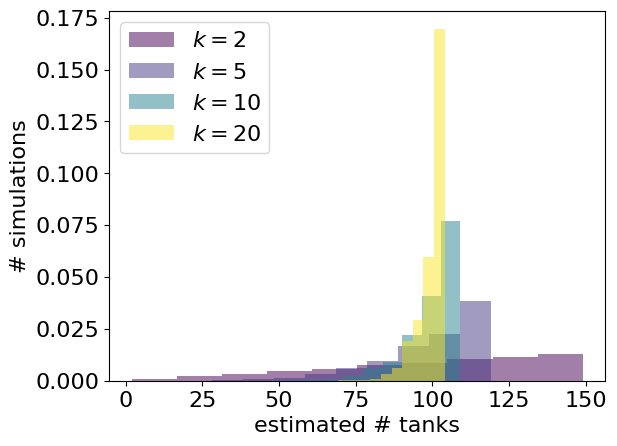

PyObject Text(30.0, 0.5, '# simulations')

In [11]:
nb_sims = 10000 # how many times we simulate tank capture to get the dist'n of the estimators

nb_tanks = 100 # n
nb_tanks_captureds = [2, 5, 10, 20] # ks

color_norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(nb_tanks_captureds), vmax=maximum(nb_tanks_captureds))
k_to_color = PyPlot.cm.ScalarMappable(norm=color_norm, cmap=get_cmap("viridis")).to_rgba

for (i, nb_tanks_captured) in enumerate(nb_tanks_captureds)
    estimated_nb_tanks = sim_̂n(nb_sims, nb_tanks, 
        nb_tanks_captured, max_serial_no_plus_gap_if_evenly_spaced)
    
    # plot histogram of estimator to viz its dist'n
    hist(estimated_nb_tanks, label="\$k=$nb_tanks_captured\$", 
        alpha=0.5, density=true, color=k_to_color(nb_tanks_captured))
end
legend(loc="upper left")
xlabel("estimated # tanks")
ylabel("# simulations")

## one-sided confidence interval

how confident are we that the Germans don't have *more* tanks?

significance level: $\alpha$

test statistic = estimator (3) = $\hat{n} = \max_i x_i + \bigl( \max_i x_i / k -1 \bigr)$

**null hypothesis**: the number of tanks is $n=n_0$<br>
**alternative hypothesis**: the number of tanks is less than $n_0$

we reject the null hypothesis (say, "the data does not support the null hypothesis") that the number of tanks is $n=n_0$ if the p-value is less than $\alpha$. the p-value is the probability that, if the null hypothesis is true, we get a test statistic equal to or smaller than we observed.

we want to find the highest $n_0$ such that we have statistical power to reject the null hypothesis in favor of the alternative hypothesis. this is the upper bound on the confidence interval!

then the idea is that, if the null hypothesis is that the number of tanks is absurdly large compared to the largest serial number we saw in our sample, it would be very unlikely that we would see such small serial numbers compared to the number of tanks, so we'd reject the null hypothesis. 

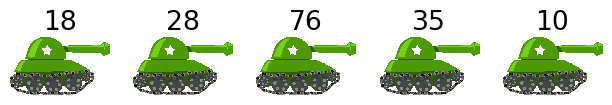

our estimate: 


90.2

In [16]:
k = 5 # number of tanks to sample
n = 100 # pretend we don't know this

captured_tanks = capture_tanks(k, n)
viz_tanks(captured_tanks)

println("our estimate: ")
n̂ = max_serial_no_plus_gap_if_evenly_spaced(captured_tanks)

say $\alpha=0.05$ and we seek a 95% one-sided confidence interval

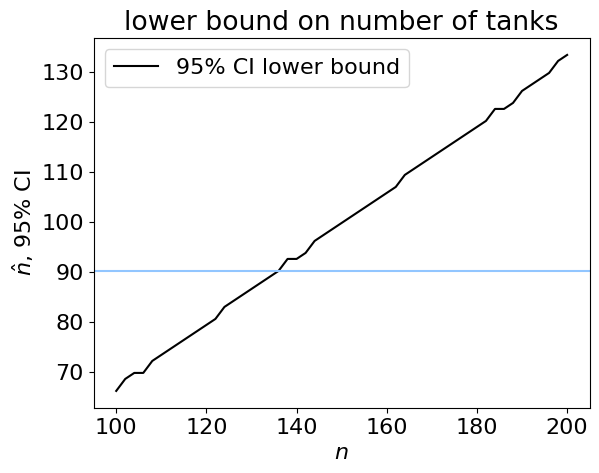

95% confidence upper limit on n̂ = 138


PyObject <matplotlib.legend.Legend object at 0x7fa08bf99a90>

In [24]:
nb_sims = 100000
ns = 100:2:200
lower_cis = zeros(length(ns))

for (i, n) in enumerate(ns)
    estimated_nb_tanks = sim_̂n(nb_sims, n, k, max_serial_no_plus_gap_if_evenly_spaced)
    lower_cis[i] = percentile(estimated_nb_tanks, 5.0)
end

# find upper limit
idx_upper_limit_on_n̂ = findfirst(lower_cis .> n̂)
println("95% confidence upper limit on n̂ = ", ns[idx_upper_limit_on_n̂])

plot(ns, lower_cis, color="k", label="95% CI lower bound")
axhline(y=n̂)
title("lower bound on number of tanks")
xlabel("\$n\$")
ylabel("\$\\hat{n}\$, 95% CI")
legend()